# Random forests for house price prediction

Your Name

The purpose of this assignment is to give you experience with ensemble methods while answering a couple of questions:
- How do random forests perform, compared to single trees?
- What are the hyperparameters of random forests?  Does tuning take a long time?
- What does the concept of "feature importance" in random forests mean? 

We'll examine these questions using the CA Housing dataset.  You can get information about the dataset here: https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset.

You will probably want to look at that web page to understand the variables in the dataset.

There are three problems to solve.

__Instructions__:
- Read this notebook to get a feeling for its structure.  Don't modify the top-level structure.
- Don't modify the cell that loads the data.
- Write code to answer the 3 problems.  Look for # YOUR CODE HERE comments.  You also need to write a summary at the end of each problem.
- Please make sure to read the grading rubric.

In [1]:
# add more imports as needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

In [2]:
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')

## Loading the data

From 8 numeric predictors we will try to predict the house value.

In [3]:
# df is a data frame of the predictors; target is a Series with the target
bunch = fetch_california_housing(as_frame=True)
df = bunch.data
target = bunch.target

## Data exploration

You can add more data exploration if you like, but you should focus on making predictions with the ensemble methods.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [5]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


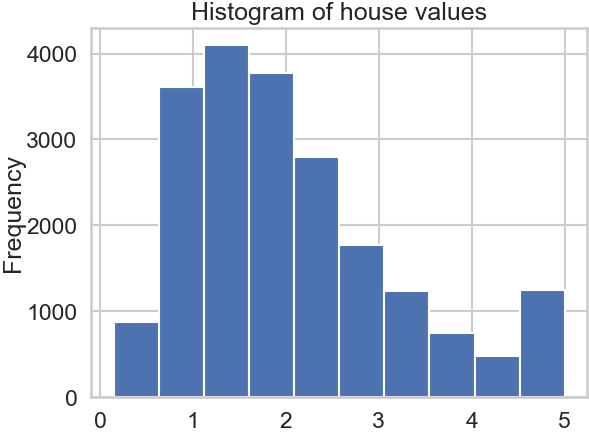

In [6]:
target.plot.hist()
plt.title('Histogram of house values');

#### Check for outlier values of predictor variables

In [7]:
# normalize to make it easier to see outliers
dfs = df.apply(zscore)

# https://stackoverflow.com/questions/41328633 explains formatting
with pd.option_context('float_format', '{:.2f}'.format): 
    print(dfs.describe(percentiles=[0.5, 0.95, 0.99])) 

        MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
count 20640.00  20640.00  20640.00   20640.00    20640.00  20640.00  20640.00   
mean      0.00      0.00      0.00      -0.00       -0.00      0.00     -0.00   
std       1.00      1.00      1.00       1.00        1.00      1.00      1.00   
min      -1.77     -2.20     -1.85      -1.61       -1.26     -0.23     -1.45   
50%      -0.18      0.03     -0.08      -0.10       -0.23     -0.02     -0.64   
95%       1.81      1.86      0.89       0.37        1.64      0.12      1.56   
99%       3.54      1.86      1.99       2.18        3.87      0.22      2.34   
max       5.86      1.86     55.16      69.57       30.25    119.42      2.96   

       Longitude  
count   20640.00  
mean       -0.00  
std         1.00  
min        -2.39  
50%         0.54  
95%         1.24  
99%         1.64  
max         2.63  


The result of describe on the z-score normalized values show some extreme outliers in variables AveRooms, AveBedrms, Population, and AveOccup.

## Data preprocessing

In this section we first remove the outliers found earlier, then perform a test/train split and scale the data.

Also, a smaller version of the dataset is created to speed up hyperparameter tuning.

#### Remove outliers in columns that have significant outliers.

In [8]:
high_vals = df.quantile(0.99)
for col in ['AveRooms', 'AveBedrms', 'Population', 'AveOccup']:
    mask = df[col] <= high_vals[col]
    df = df[mask]
    target = target[mask]

#### How many rows after outlier removal? 

In [9]:
print(f'Number of rows in data frame: {df.shape[0]}')

Number of rows in data frame: 20000


#### Transform the data to NumPy arrays, perform a train/test split, and then scale the data.

The test data is not used in fitting the scaler -- that would "leak" information about the test data.

In [10]:
X = df.values
y = target.values

# 20% should be enough for the test set, as the data set has 20K rows
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Make a smaller version of the training data to allow for faster hyperparameter tuning.

In [11]:
# Use 50% of the data in the sample
m = X_train.shape[0]
rows = np.random.choice(m, size=int(m*0.5), replace=False)
X_train_s = X_train[rows]
y_train_s = y_train[rows]

In [12]:
X_train_s.shape

(8000, 8)

## Problem 1. Regression with a single regression tree

### Hyperparameter tuning using GridSearchCV

In [30]:
param_grid = {'max_leaf_nodes': [32, 64, 128, 256], 'max_depth': [4, 8, 12, 18, 32]}

tree_grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, scoring='neg_mean_squared_error', cv=10)
tree_grid_search.fit(X_train_s, y_train_s)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [4, 8, 12, 18, 32],
                         'max_leaf_nodes': [32, 64, 128, 256]},
             scoring='neg_mean_squared_error')

In [31]:
df_tree = pd.DataFrame(tree_grid_search.cv_results_)
df_tree['mean RMSE'] = np.sqrt(-df_tree['mean_test_score'])

The tree does not appear to be very sensitive to the max_depth or the max_leaf_nodes hyperparameters.  It appears that max_depth values of about 10-20 work well, in conjunction with max_leaf_nodes values of about 100-200.

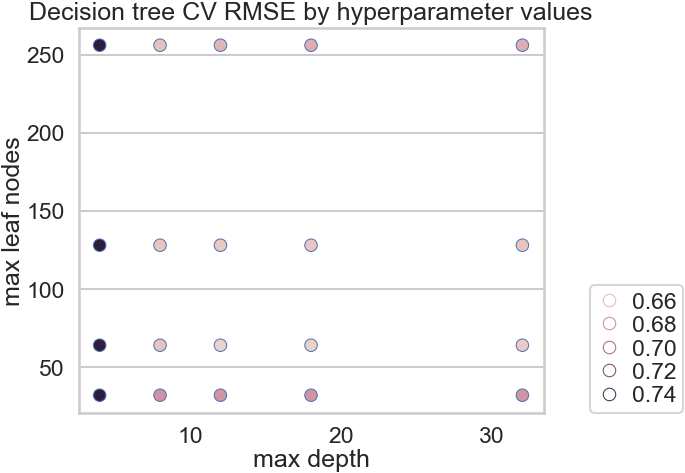

In [15]:
plt.figure(figsize=(6,5))
sns.scatterplot(data=df_tree, x='param_max_depth', y='param_max_leaf_nodes', hue='mean RMSE')
plt.xlabel('max depth')
plt.ylabel('max leaf nodes')
plt.title('Decision tree CV RMSE by hyperparameter values')
plt.legend(bbox_to_anchor=(1.3,0), loc='lower right', borderaxespad=0);

### Report on the best parameters and the score associated with them.

In [16]:
print(f'best hyperparameter values: {tree_grid_search.best_params_}')
print(f'CV RMSE for best hyperparameters: {np.sqrt(-tree_grid_search.best_score_):0.3f}')

best hyperparameter values: {'max_depth': 12, 'max_leaf_nodes': 64}
CV RMSE for best hyperparameters: 0.649


### Feature importance

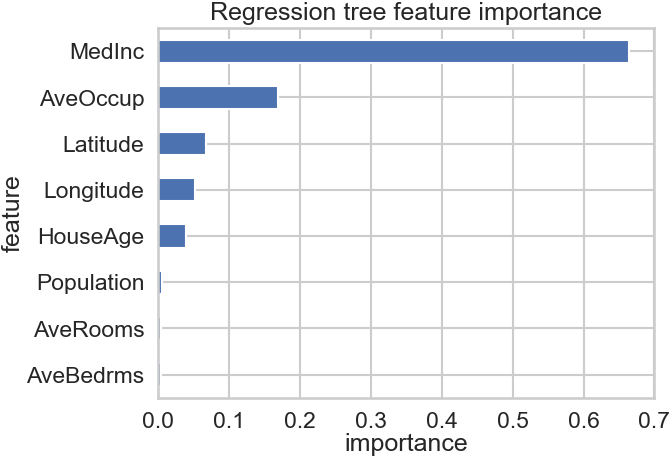

In [17]:
importance = pd.Series(tree_grid_search.best_estimator_.feature_importances_)
importance.index = df.columns
importance.sort_values().plot.barh(title='Regression tree feature importance')
plt.xlim(0, 0.7)
plt.xlabel('importance')
plt.ylabel('feature');

### Summary

We achieve a CV RMSE of about 0.64 with a single tree.  A max depth of 18 was found through grid search, which is surprisingly deep.

Using the regression tree concept of feature importance, median income was found to be, by far, the most important feature.  This is not surprising; people with higher income tend to spend more on their house.  I think this is especially true in California, where housing is very expensive.  On the other hand, it is not very helpful to know that median income predicts house price, because median income can be hard information to get.

## Problem 2. Regression with a random forest

### Hyperparameter tuning

Note that a `max_features` value of 1 means "bagged trees".

In [18]:
param_grid = {'max_depth': [2, 4, 8, None], 'max_features': [1.0, 'sqrt']}

forest_grid_search = GridSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=10)
forest_grid_search.fit(X_train_s, y_train_s)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, 8, None],
                         'max_features': [1.0, 'sqrt']},
             scoring='neg_mean_squared_error')

### Report on the best parameters and the score associated with them.

In [19]:
best_rmse = np.sqrt(-forest_grid_search.best_score_)
best_hyper_vals = forest_grid_search.best_params_
print(f'best hyperparameter values: {best_hyper_vals}')
print(f'CV RMSE for best hyperparameters: {best_rmse:0.3f}')

best hyperparameter values: {'max_depth': None, 'max_features': 'sqrt'}
CV RMSE for best hyperparameters: 0.512


### Feature importance

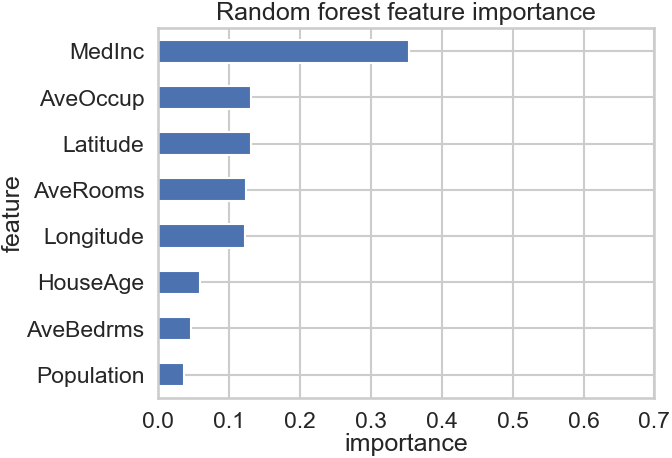

In [20]:
importance = pd.Series(forest_grid_search.best_estimator_.feature_importances_)
importance.index = df.columns
importance.sort_values().plot.barh(title='Random forest feature importance')
plt.xlim(0, 0.7)
plt.xlabel('importance')
plt.ylabel('feature');

### Summary

A CV RMSE of about 0.52 was obtained using a random forest regressor.  This is a big improvement over the value of 0.64 we got with a single regression tree.

Surprisingly, the best value of hyperparameter max_depth found through tuning was 'None', meaning no limit on depth.  Since random forest are usuall built by very shallow trees, this was a surprise.

For hyperparameter max_features, value 'sqrt' was found to be better than value 1.0, which gives simply bagged trees, not random forests.  This means that the feature of random forests, in which some random features are dropped at each tree node, appears to be valuable.

It was also interesting to see the the feature importance results were very different for random forest than for a single tree.  Median income is still the best feature, but now the average number of rooms was one of the most important features.  With a single tree the average number of rooms was the least significant figure.

## Problem 3. Tuning the number of base regressors

Now we find the best number of best regressors, keeping the hyperparameter values in the last part unchanged.

In [21]:
# extend best hyperparameter values with number of estimators
param_grid = {k: [v] for k, v in best_hyper_vals.items()}
param_grid['n_estimators'] = [50, 100, 200, 300, 400]

In [22]:
print(param_grid)

{'max_depth': [None], 'max_features': ['sqrt'], 'n_estimators': [50, 100, 200, 300, 400]}


In [23]:
forest_grid_search = GridSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=5)
forest_grid_search.fit(X_train_s, y_train_s)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None], 'max_features': ['sqrt'],
                         'n_estimators': [50, 100, 200, 300, 400]},
             scoring='neg_mean_squared_error')

In [24]:
print(f'best hyperparameter values: {forest_grid_search.best_params_}')
print(f'CV RMSE for best hyperparameters: {np.sqrt(-forest_grid_search.best_score_):0.3f}')

best hyperparameter values: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 400}
CV RMSE for best hyperparameters: 0.511


#### Examine how score varies by the number of estimators

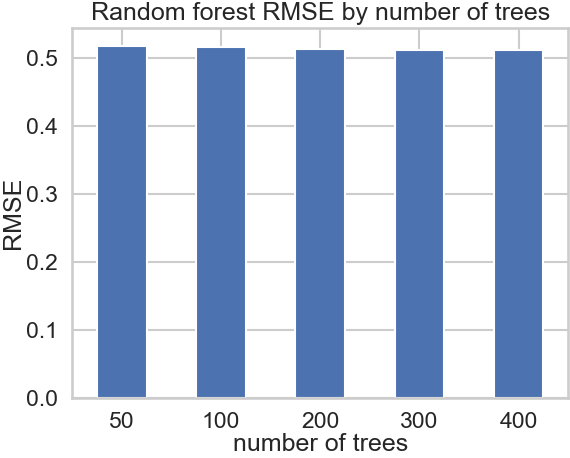

In [25]:
rf_results = pd.DataFrame(forest_grid_search.cv_results_)
rf_scores = pd.Series(np.sqrt(-rf_results['mean_test_score']))
rf_scores.index = rf_results['param_n_estimators']
rf_scores.plot.bar(rot=0, title='Random forest RMSE by number of trees')
plt.xlabel('number of trees')
plt.ylabel('RMSE');

### Summary

We see that the RMSE score doesn't change significantly in moving from 100 to 400 estimators.

## Problem 4. Feature importance with forward feature selection

To save time, we'll use a random forest with 50 trees.

In [26]:
rf = RandomForestRegressor(n_estimators=50)
forward_fs = SequentialFeatureSelector(rf, n_features_to_select='auto', scoring='neg_mean_squared_error')
forward_fs.fit(X_train_s, y_train_s)

SequentialFeatureSelector(estimator=RandomForestRegressor(n_estimators=50),
                          scoring='neg_mean_squared_error')

In [27]:
best_features = df.columns[forward_fs.support_]
print(f"best features: {','.join(best_features)}")

best features: MedInc,Population,Latitude,Longitude


### Summary

What is interesting here is that population is found to be the second-best feature when used in conjunction with median income.  Really, forward feature selection is doing something quite different from feature importance with trees.  In forward feature selection, we are learning about which features work well together.  